In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline, Pipeline
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

In [2]:
rs=121
stocks=['aapl','googl','nvda','dal','xom','cvx','vz']

We use smoothened state data on unsmoothened test data

In [3]:
init_dir_path = str(os.getcwd())
data=pd.read_csv(init_dir_path+'/stock_hmm_output.csv',engine='python').drop(['Unnamed: 0'],axis=1)
smooth_data=pd.read_csv(init_dir_path+'/stock_hmm_output_kalman.csv',engine='python').drop(['Unnamed: 0'],axis=1)
features=['Smooth_Return','Volatility','Smooth_HighR','Smooth_LowR']
target='State'
data[target] = smooth_data[target] 

In [4]:
final_test=[]
stocks_data=[]
ft_size=400
for x in data.groupby(['Ticker']):
    final_test.append(x[1][-ft_size:])
    stocks_data.append(x[1][:-ft_size])

In [37]:
def create_sliding_window(train_df, test_df, features, target, window=7):
    splitter = SlidingWindowSplitter(window_length=window, step_length=1, fh=[1])
    train_x, train_y, test_x, test_y = [], [], [], []

    for idx in splitter.split(train_df):
        X = train_df.iloc[idx[0]][features].values.flatten()
        y = train_df.iloc[idx[1]][target].values.flatten()[0]
        train_x.append(X)
        train_y.append(y)

    for idx in splitter.split(test_df):
        X = test_df.iloc[idx[0]][features].values.flatten()
        y = test_df.iloc[idx[1]][target].values.flatten()[0]
        test_x.append(X)
        test_y.append(y)

    return (train_x, train_y), (test_x, test_y)

In [5]:
testing_size=500
ns=5
tss=TimeSeriesSplit(n_splits=ns,test_size=testing_size)
spread_range = range(2, 25)

Skip the two cells below if you have access to the saved training windows

In [8]:
training_lists = {}
testing_lists = {}
for spread in spread_range:
    training_lists[spread] = {}
    testing_lists[spread] = {}
    for ticker_idx, ticker_df in enumerate(stocks_data):
        ticker = list(ticker_df["Ticker"])[0]
        training_list = [[[], []] for _ in range(ns)]
        testing_list = [[[], []] for _ in range(ns)]
        for fold_idx, (train_idx, test_idx) in enumerate(tss.split(ticker_df)):
            train_df = ticker_df.iloc[train_idx]
            test_df = ticker_df.iloc[test_idx]           
            (train_x, train_y), (test_x, test_y) = create_sliding_window(train_df, test_df, features, target, window=spread)
            training_list[fold_idx][0] += train_x
            training_list[fold_idx][1] += train_y
            testing_list[fold_idx][0] += test_x
            testing_list[fold_idx][1] += test_y
        training_lists[spread][stocks.index(ticker)] = training_list
        testing_lists[spread][stocks.index(ticker)] = testing_list #spread->stock index->time series split->data/label

In [ ]:
with open('saved_training_lists_kalman_unsmoothened.pkl', 'wb') as f:
    pickle.dump(training_lists, f)

with open('saved_testing_lists_kalman_unsmoothened.pkl', 'wb') as f:
    pickle.dump(testing_lists, f)

Load training, test windows here. 
They're saved for complexity reasons, RUN CODE from here

In [6]:
with open('saved_training_lists_kalman_unsmoothened.pkl', 'rb') as f:
    training_lists = pickle.load(f)

with open('saved_testing_lists_kalman_unsmoothened.pkl', 'rb') as f:
    testing_lists = pickle.load(f)

In [7]:
def accuracies_model(model_dict, window, stock_ind, map=True):
    a=0
    
    y_true_all=[]
    y_pred_all=[]
    if map:
        model = model_dict[window][stock_ind]
    else:
        model = model_dict
    for i in range(ns):
        model.fit(X=training_lists[window][stock_ind][i][0],y=training_lists[window][stock_ind][i][1])
        y_pred=model.predict(testing_lists[window][stock_ind][i][0])
        y_true=testing_lists[window][stock_ind][i][1]
        a+= accuracy_score(y_true,y_pred)
        y_true_all=y_true_all+list(y_true)
        y_pred_all=y_pred_all+list(y_pred)
    A=confusion_matrix(y_true=y_true_all,y_pred=y_pred_all)
    f1_score = (2*A[0][0]/(2*A[0][0]+A[0][1]+A[1][0]))
    a=a/ns
    return (a,f1_score)

In [8]:
def plot_accuracies(accuracies, model_type): #accuracies needs to be a nested dictionary window->stock index
    for stock_ind in range(len(stocks)):
        vals = [[],[]]
        colors = {0: 'blue', 1: 'orange'}
        labels = {0: "accuracy score", 1: "f1_score"}
        for window in accuracies.keys():
            vals[0].append(accuracies[window][stock_ind][0])
            vals[1].append(accuracies[window][stock_ind][1])
        plt.figure(figsize=(6, 4))
        for i in range(2):
            plt.plot(list(accuracies.keys()), vals[i], marker='o',c=colors[i], label = labels[i])
        plt.title(f"{model_type} scores for {stocks[stock_ind]}")
        plt.xlabel("Window size")
        plt.ylabel("Score")
        plt.legend()
        plt.tight_layout()
        plt.show()

In [57]:
f1_xgb = {}
for window in spread_range:
    f1_xgb[window] = {}
    for stock_ind in range(len(stocks)):
        model = XGBClassifier(tree_method = "hist", device="cuda")
        f1_xgb[window][stock_ind] = accuracies_model(model ,window,stock_ind, map=False)

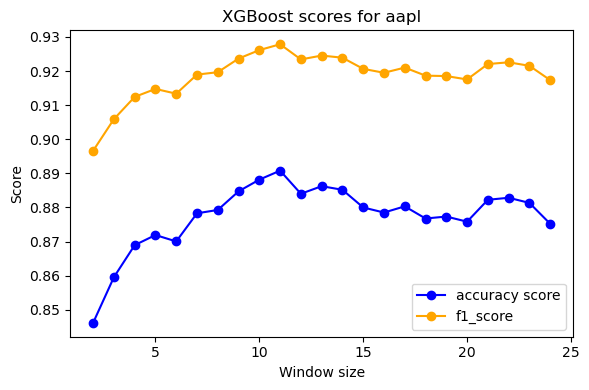

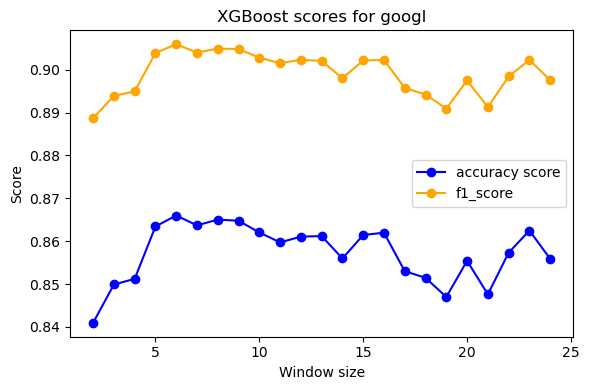

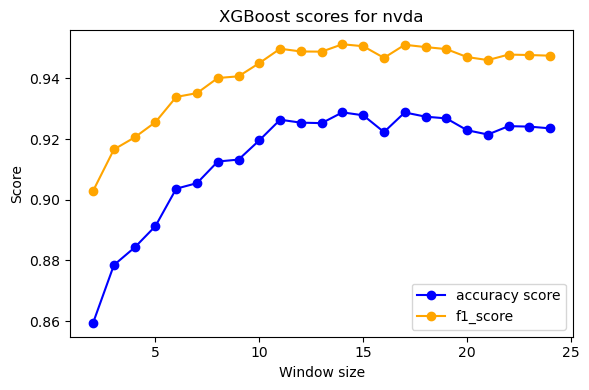

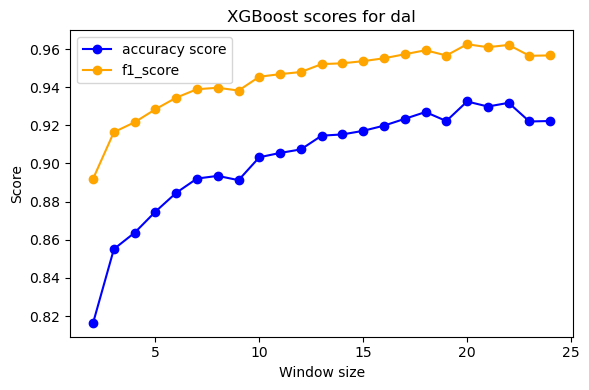

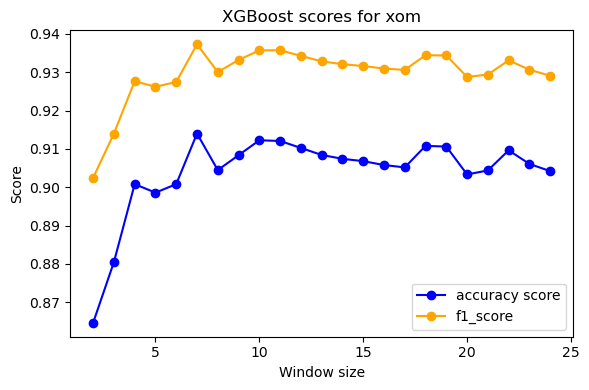

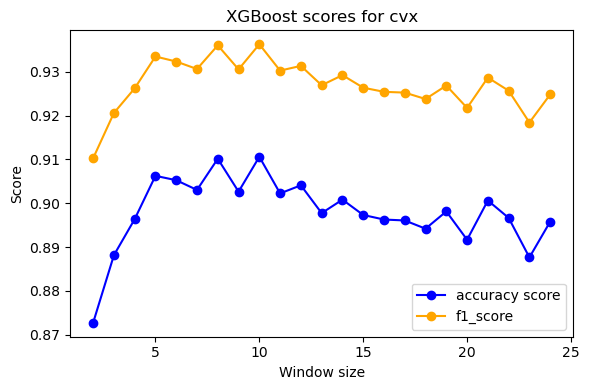

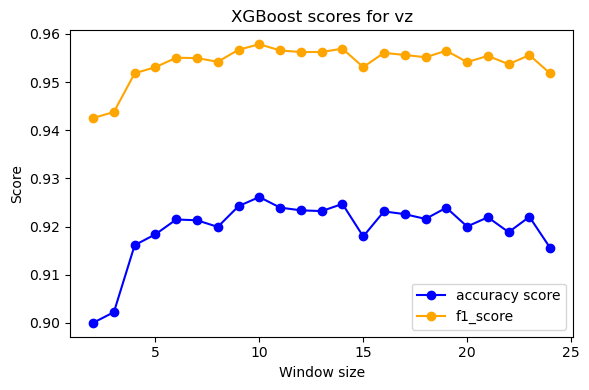

In [47]:
plot_accuracies(f1_xgb, "XGBoost")

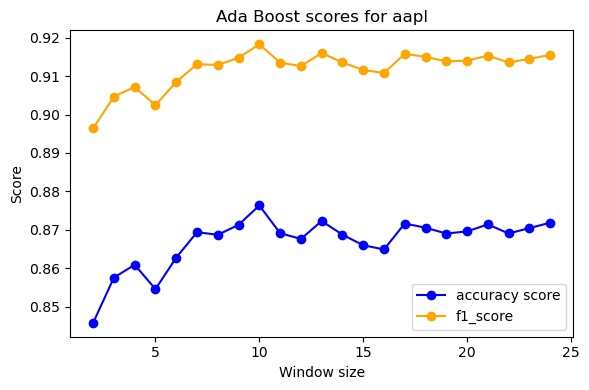

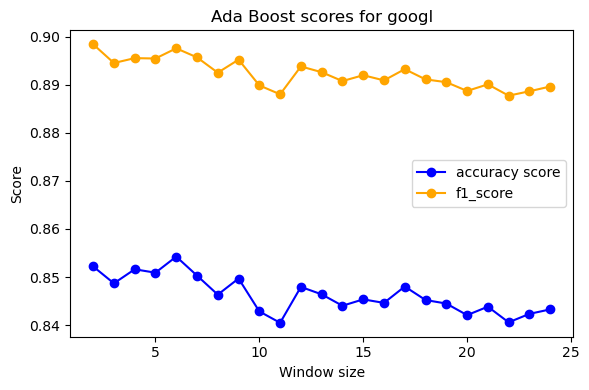

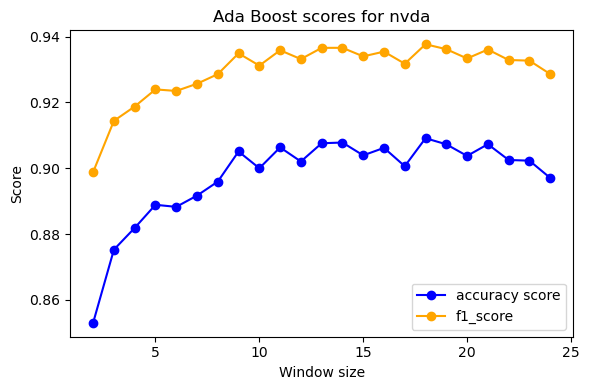

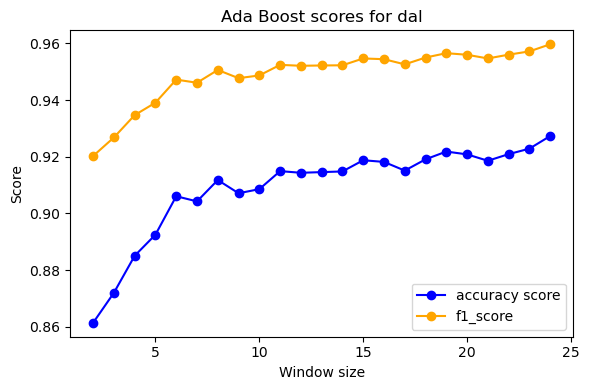

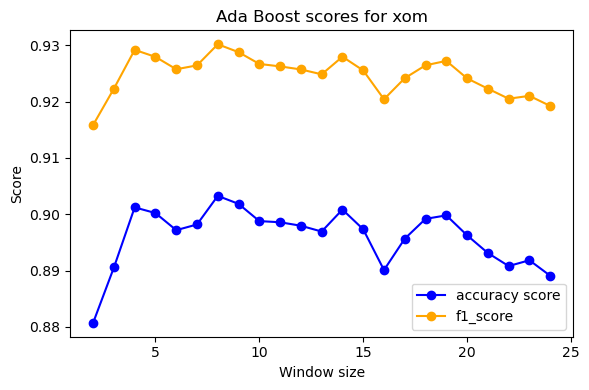

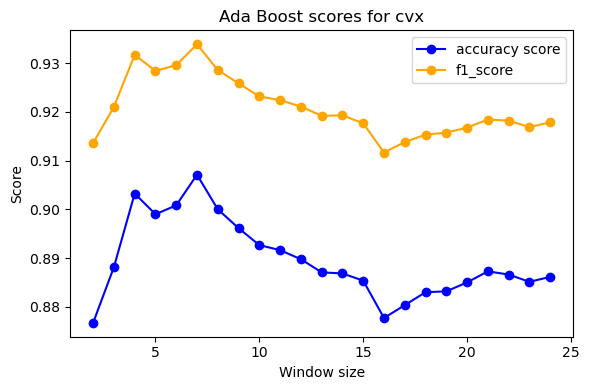

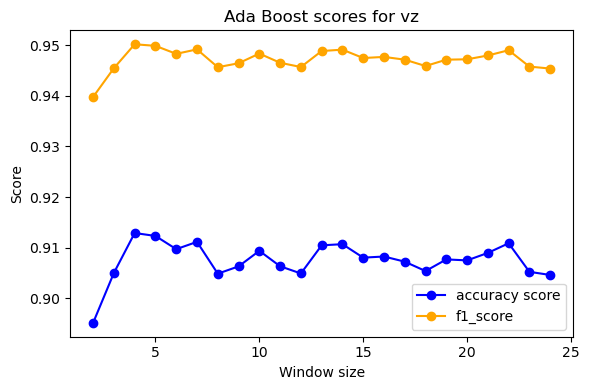

In [48]:
f1_ada = {}
for window in spread_range:
    f1_ada[window] = {}
    for stock_ind in range(len(stocks)):
        ada_model = AdaBoostClassifier(n_estimators=100,random_state=121)
        f1_ada[window][stock_ind] = accuracies_model(ada_model,window,stock_ind,map=False)
plot_accuracies(f1_ada, "Ada Boost")

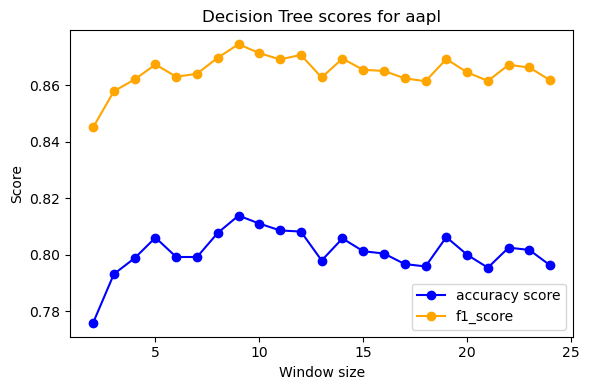

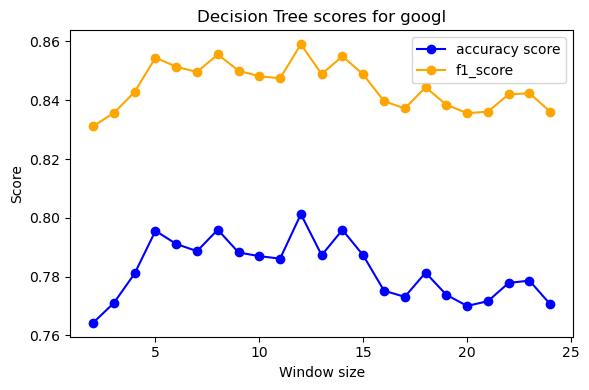

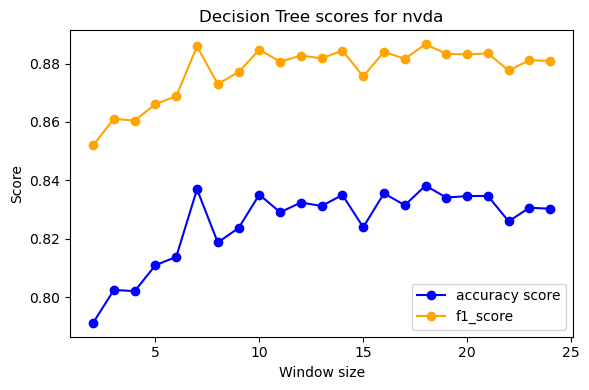

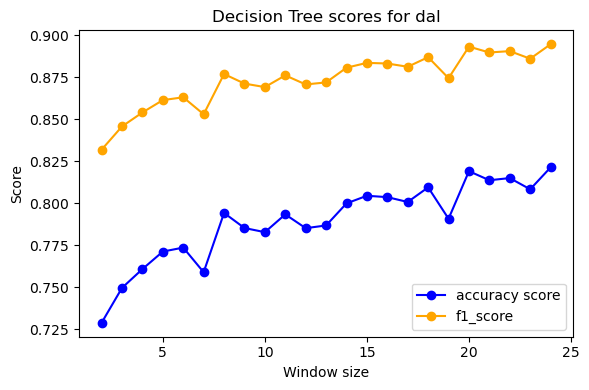

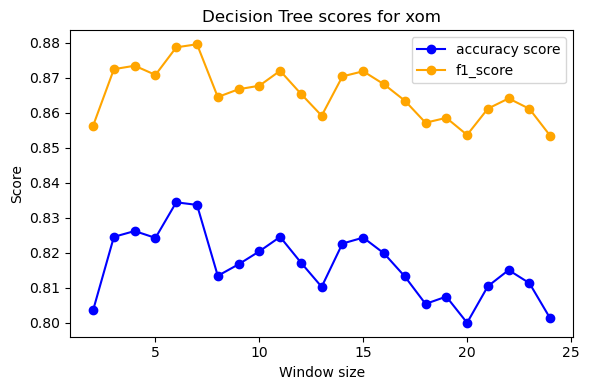

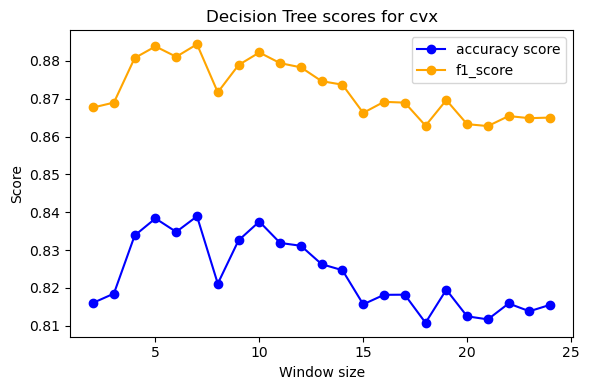

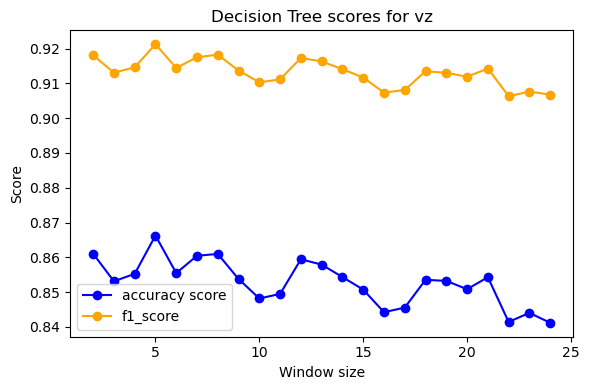

In [49]:
f1_decision = {}
for window in spread_range:
    f1_decision[window] = {}
    for stock_ind in range(len(stocks)):
        decision_model = DecisionTreeClassifier(random_state=rs)
        f1_decision[window][stock_ind] = accuracies_model(decision_model,window,stock_ind,map=False)
plot_accuracies(f1_decision, "Decision Tree")

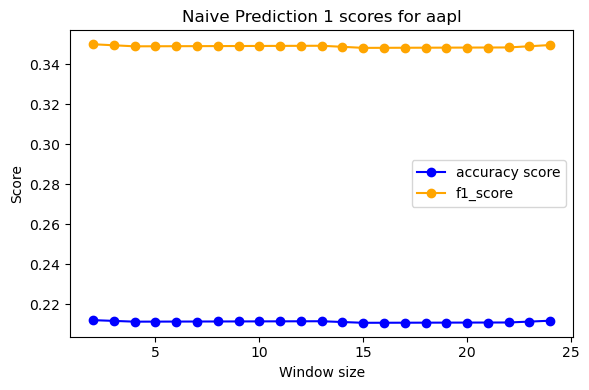

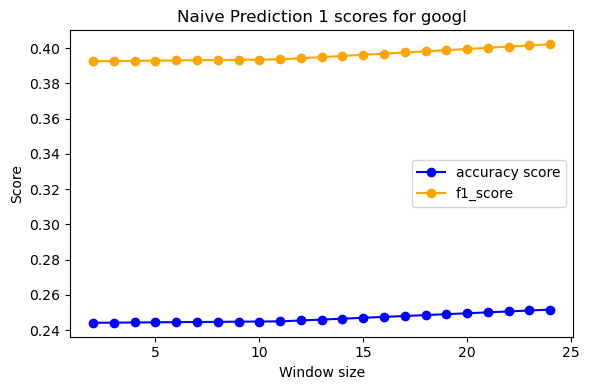

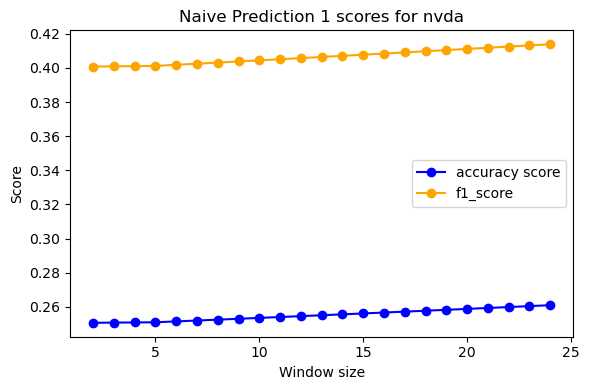

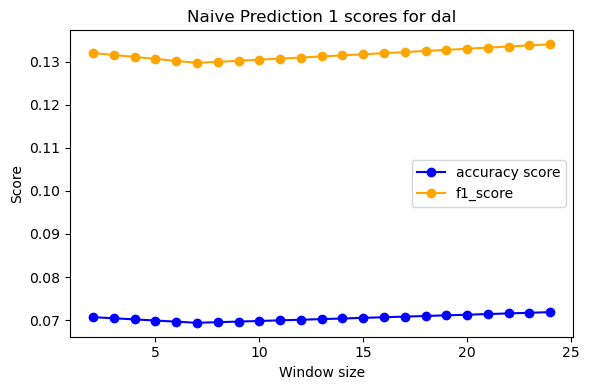

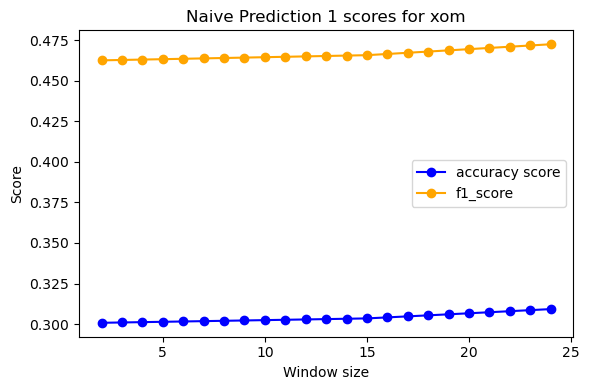

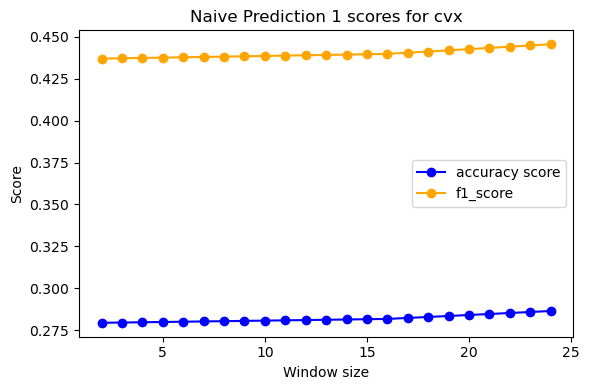

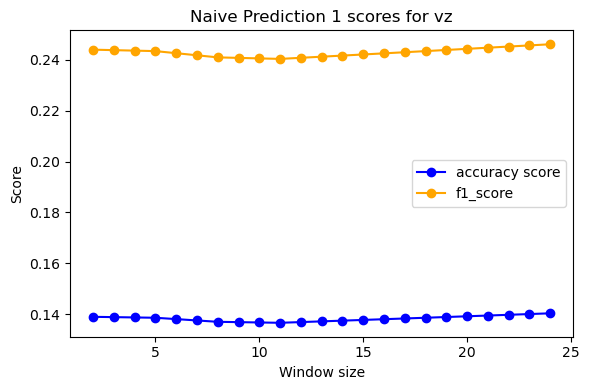

In [31]:
#Naive Prediction
f1_naive_1 = {}
for window in spread_range:
    f1_naive_1[window] = {}
    for stock_ind in range(len(stocks)):
        y_true_all = []
        y_pred_all = []
        for i in range(ns):
            y_pred=[1]*len(testing_lists[window][stock_ind][i][1])
            y_true=testing_lists[window][stock_ind][i][1]
            y_true_all+=list(y_true)
            y_pred_all+=list(y_pred)
        f1_naive_1[window][stock_ind] = [accuracy_score(y_true=y_true_all,y_pred=y_pred_all), f1_score(y_true=y_true_all,y_pred=y_pred_all)]
plot_accuracies(f1_naive_1, "Naive Prediction 1")

In [35]:
#Naive Prediction
f1_naive_0 = {}
for window in spread_range:
    f1_naive_0[window] = {}
    for stock_ind in range(len(stocks)):
        y_true_all = []
        y_pred_all = []
        for i in range(ns):
            y_pred=[1]*len(testing_lists[window][stock_ind][i][1])
            y_true=[1-w for w in testing_lists[window][stock_ind][i][1]]
            y_true_all+=list(y_true)
            y_pred_all+=list(y_pred)
        f1_naive_0[window][stock_ind] = [accuracy_score(y_true=y_true_all,y_pred=y_pred_all), f1_score(y_true=y_true_all,y_pred=y_pred_all)]

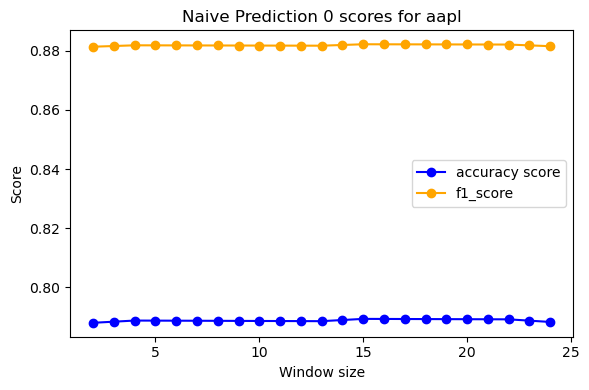

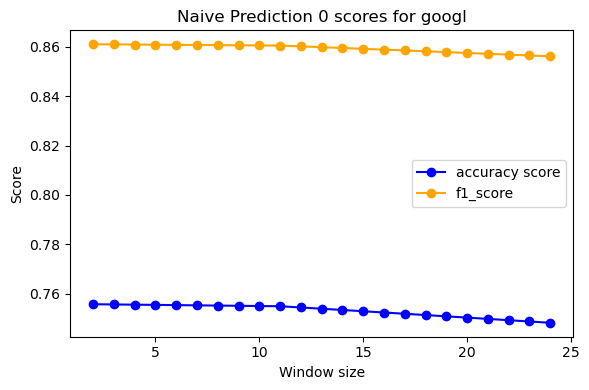

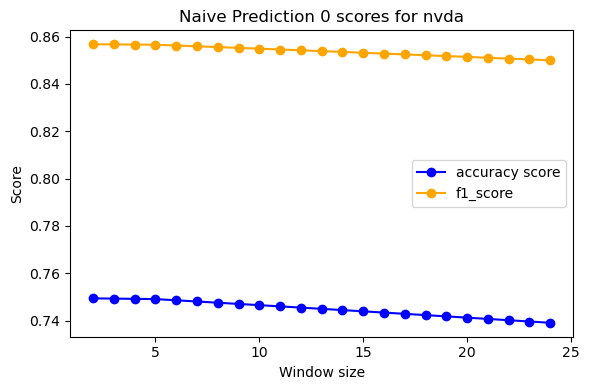

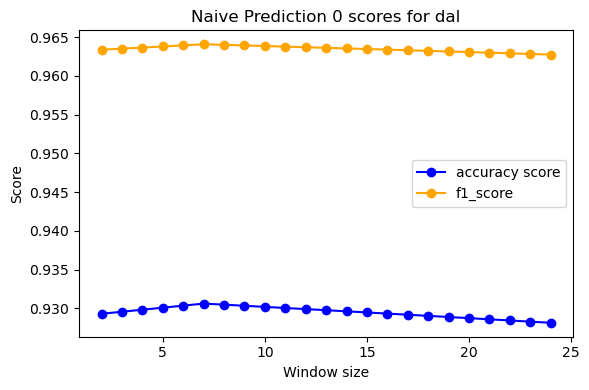

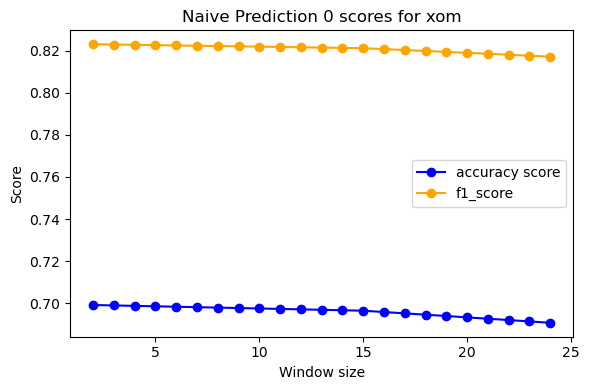

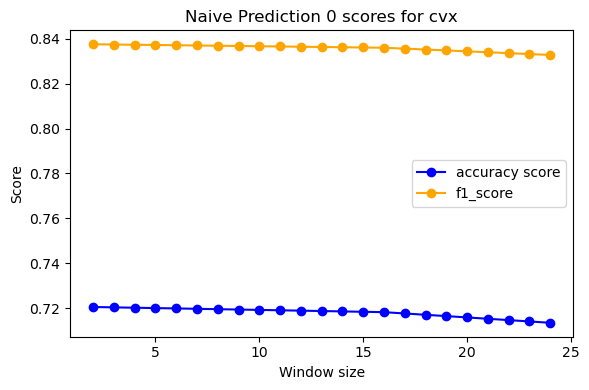

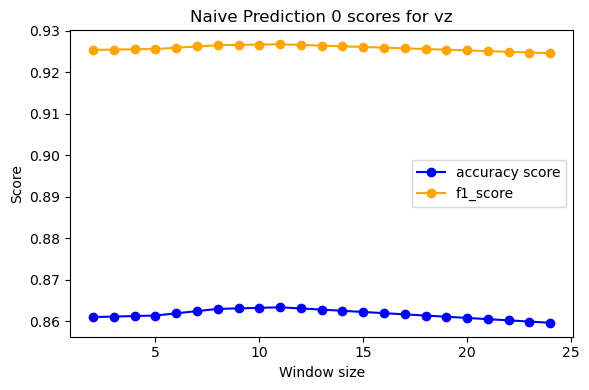

In [37]:
plot_accuracies(f1_naive_0, "Naive Prediction 0")

In [50]:
from copy import deepcopy
model_forest = RandomForestClassifier(
    n_estimators = 100, # number of trees in ensemble
    max_depth = 10, # max_depth of each tree
    min_samples_leaf = 5, 
    max_features = 5, # default is round(sqrt(num_features)), which in this case is 1.
    random_state = 121 # for consistency
    )

In [51]:
f1_rfc = {}
for window in spread_range:
    f1_rfc[window] = {}
    for stock_ind in range(len(stocks)):
        rfc_model = deepcopy(model_forest)
        f1_rfc[window][stock_ind] = accuracies_model(rfc_model,window,stock_ind,map=False)

In [52]:
f1_knn = {}
for window in spread_range:
    f1_knn[window] = {}
    for stock_ind in range(len(stocks)):
        knn_model = KNeighborsClassifier()
        f1_knn[window][stock_ind] = accuracies_model(knn_model,window,stock_ind,map=False)

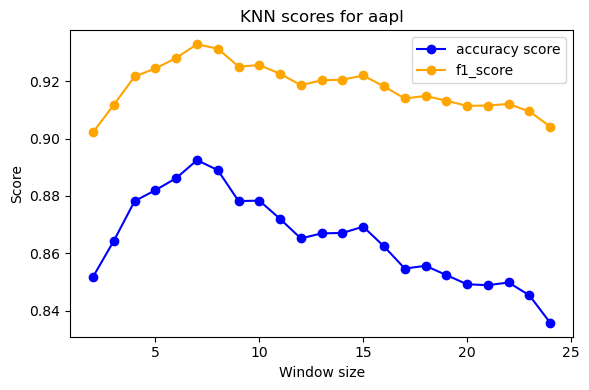

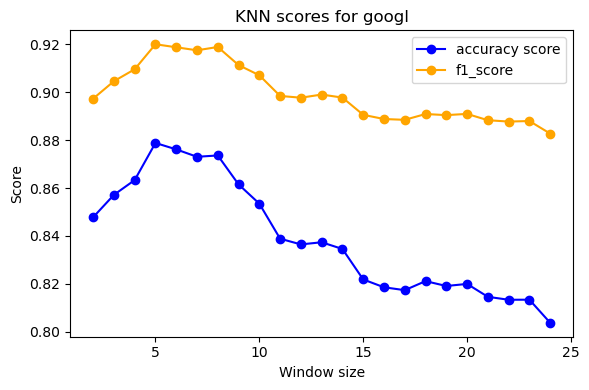

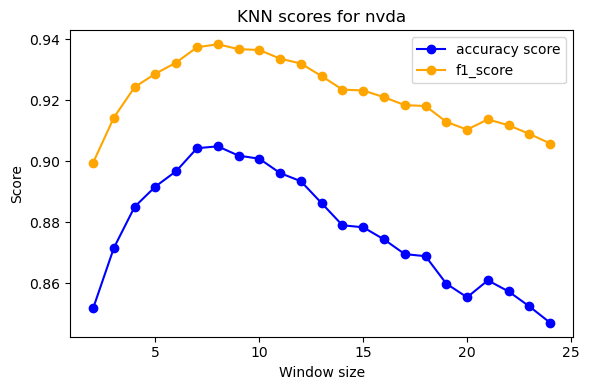

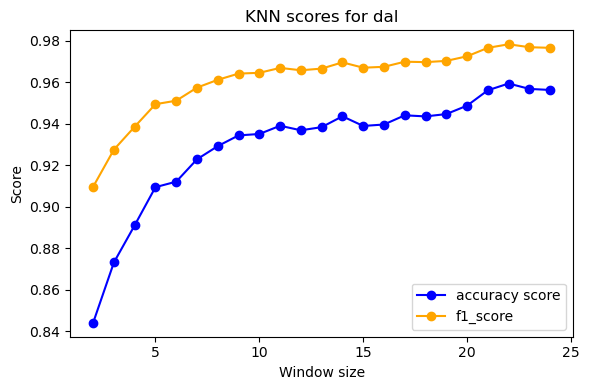

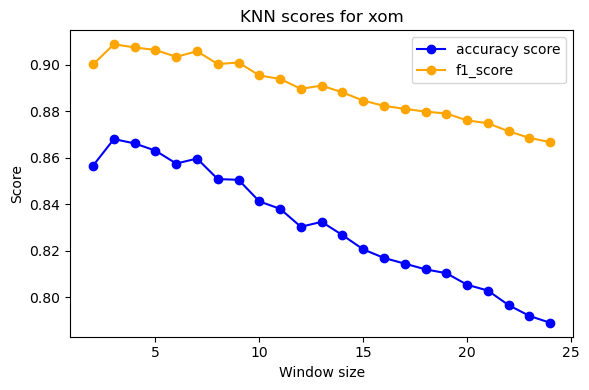

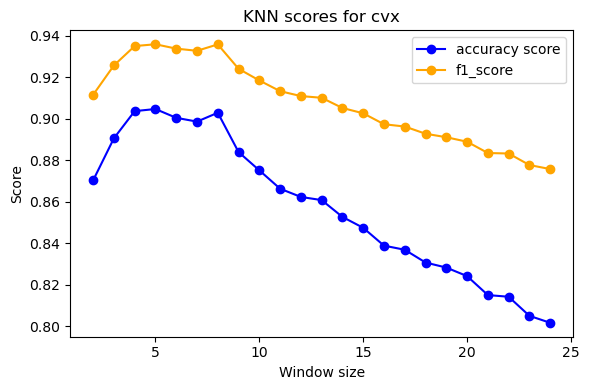

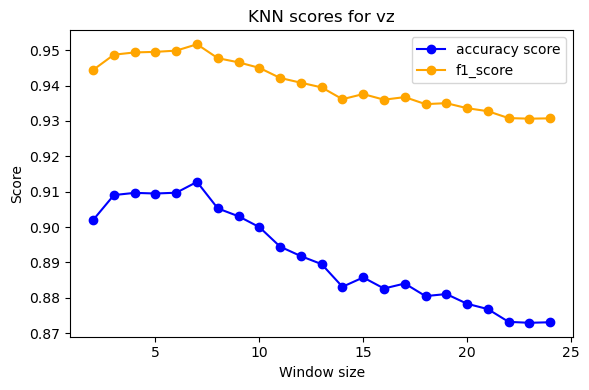

In [48]:
plot_accuracies(f1_knn, "KNN")

In [53]:
with open('best_xgb.pkl', 'rb') as f:
    best_xgb = pickle.load(f)

f1_tuned = {}
for window in spread_range:
    f1_tuned[window] = {}
    for stock_ind in range(len(stocks)):
        model = best_xgb[window][stock_ind]
        f1_tuned[window][stock_ind] = accuracies_model(model ,window,stock_ind, map=False)

c:\Users\18585\anaconda3\envs\erdos_spring_2025\Lib\site-packages\xgboost\core.py:729: UserWarning: [02:09:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [54]:
with open('best_logistic.pkl', 'rb') as f:
    best_logistic = pickle.load(f)

f1_logistic_tuned = {}
for window in spread_range:
    f1_logistic_tuned[window] = {}
    for stock_ind in range(len(stocks)):
        model = best_logistic[window][stock_ind]
        f1_logistic_tuned[window][stock_ind] = accuracies_model(model, window, stock_ind, map=False)

c:\Users\18585\anaconda3\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\18585\anaconda3\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\18585\anaconda3\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\18585\anaconda3\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\18585\anaconda3\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

In [55]:
f1_svm = {}
for window in spread_range:
    f1_svm[window] = {}
    for stock_ind in range(len(stocks)):
        svm_model = SVC(random_state=rs)
        f1_svm[window][stock_ind] = accuracies_model(svm_model, window, stock_ind, map=False)

In [58]:
accuracies_over_models = [f1_naive_0,f1_naive_1, f1_xgb,f1_ada,f1_decision,f1_rfc, f1_knn, f1_tuned, f1_logistic_tuned,f1_svm]
model_names = ["Naive_0","Naive_1","XGBoost","Ada Boosting", "Decision Tree","Random Forest Classifier","KNN", "Tuned XGBoost","Tuned Logistic Regression","SVM"]

In [59]:
best_accs = {}
for stock_ind in range(len(stocks)):
    best_accs[stock_ind] = {}
    for ind, model in enumerate(accuracies_over_models):
        accs_model_windows = [model[window][stock_ind][1] for window in spread_range]
        max_acc_model = max(accs_model_windows)
        best_accs[stock_ind][ind] = (max_acc_model,spread_range[accs_model_windows.index(max_acc_model)])

In [61]:
data_after_training = {}
data_after_training["Models(rows)/Stocks(columns)"] = model_names
for stock in stocks:
    data_after_training[stock] = []
    for ind, model in enumerate(accuracies_over_models):
        data_after_training[stock].append(best_accs[stocks.index(stock)][ind])
df_test_scores = pd.DataFrame(data_after_training)
df_test_scores.set_index("Models(rows)/Stocks(columns)")
df_test_scores.to_csv('model_performances.csv')

In [62]:
df_test_scores

,Models(rows)/Stocks(columns),aapl,googl,nvda,dal,xom,cvx,vz
0,Naive_0,"(0.8822309287854344, 15)","(0.8609332113449222, 2)","(0.8567493112947658, 2)","(0.9640680815297331, 7)","(0.8229732923658709, 2)","(0.8375350140056023, 2)","(0.9266900790166813, 11)"
1,Naive_1,"(0.3499005964214712, 2)","(0.40214837193689157, 24)","(0.4138620459846718, 24)","(0.13406507252058017, 24)","(0.472400513478819, 24)","(0.44546048334421945, 24)","(0.24613117170228446, 24)"
2,XGBoost,"(0.9278573358551743, 11)","(0.9059391872691105, 6)","(0.9512538743307974, 14)","(0.9625, 20)","(0.9372781065088758, 7)","(0.9363186972957255, 10)","(0.9578579743888243, 10)"
3,Ada Boosting,"(0.9183068212456188, 10)","(0.898398674765323, 2)","(0.9376955903271693, 18)","(0.9596642574026579, 24)","(0.9301643192488263, 8)","(0.9338723650014439, 7)","(0.9501615136132903, 4)"
4,Decision Tree,"(0.8744850315847295, 9)","(0.8590526009880849, 12)","(0.8866279069767442, 18)","(0.8947238048055487, 24)","(0.8795534665099882, 7)","(0.8844250363901018, 7)","(0.9212467285272424, 5)"
5,Random Forest Classifier,"(0.9031556039173014, 4)","(0.9040632054176072, 4)","(0.9380224848659556, 22)","(0.9603174603174603, 24)","(0.9300239234449761, 22)","(0.9395667046750285, 7)","(0.9541966984422228, 10)"
6,KNN,"(0.9329623071085251, 7)","(0.919957310565635, 5)","(0.9383236689509752, 8)","(0.9783143304270064, 22)","(0.9087367835281024, 3)","(0.9358346927678086, 5)","(0.9516745336030569, 7)"
7,Tuned XGBoost,"(0.9283202596700028, 10)","(0.9086221712976225, 8)","(0.9533707865168539, 13)","(0.9690625726913236, 24)","(0.939540507859734, 17)","(0.9465992130410343, 6)","(0.9608257095941825, 13)"
8,Tuned Logistic Regression,"(0.9326027397260274, 22)","(0.9212730318257957, 6)","(0.9620111731843576, 13)","(0.9724137931034482, 21)","(0.9504424778761061, 11)","(0.955623778956182, 7)","(0.9609580838323353, 24)"
9,SVM,"(0.9423076923076923, 11)","(0.9173999432302016, 8)","(0.9588660366870484, 10)","(0.9756880733944954, 22)","(0.9448584202682563, 10)","(0.941415313225058, 8)","(0.9641120629775412, 8)"


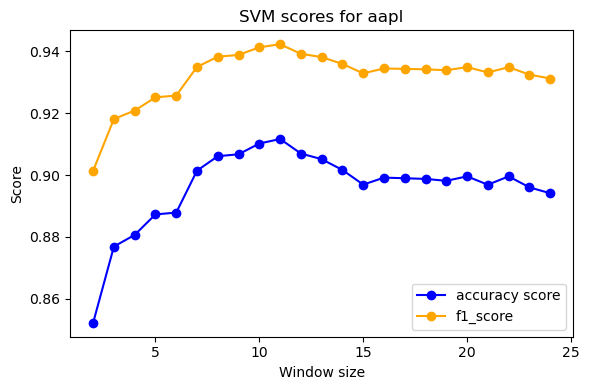

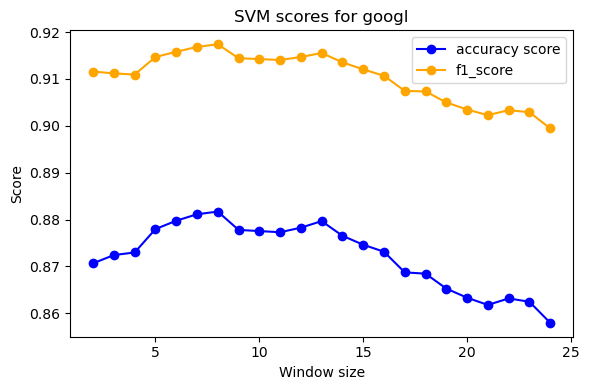

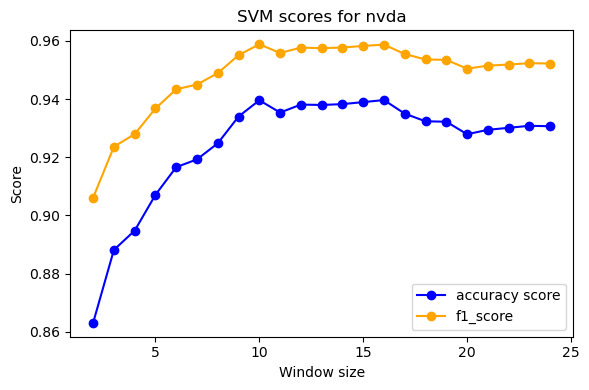

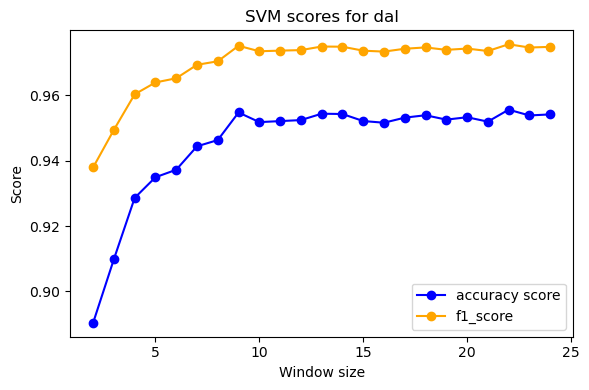

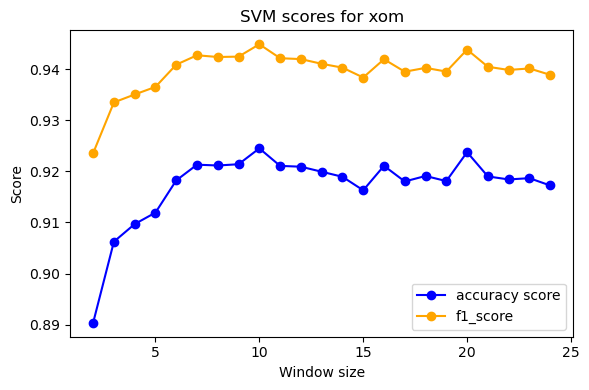

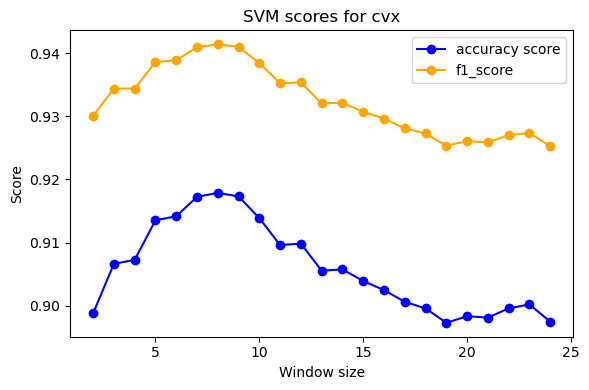

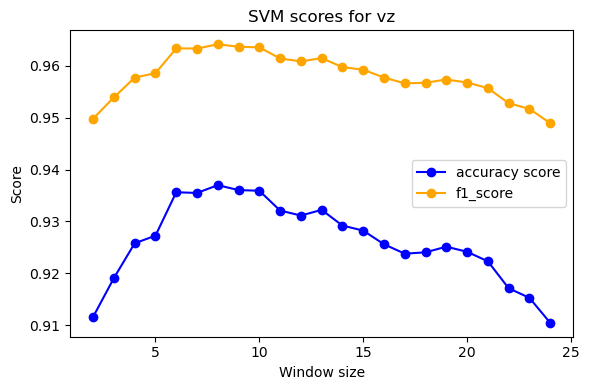

In [60]:
plot_accuracies(f1_svm, "SVM")

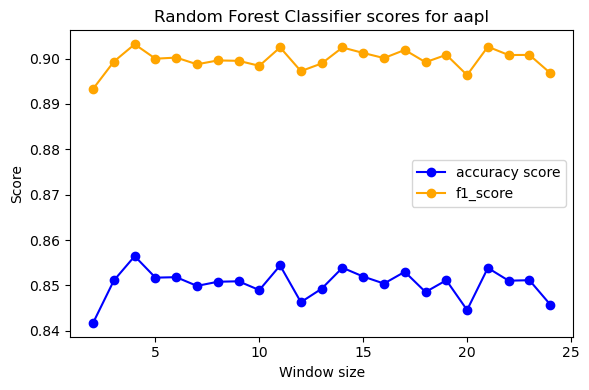

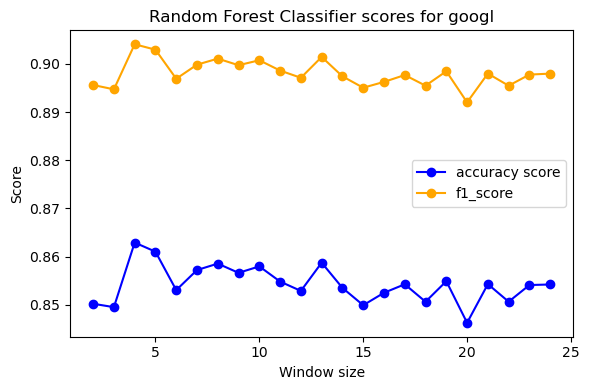

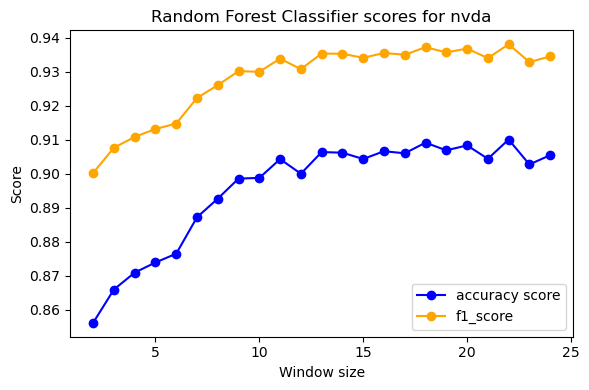

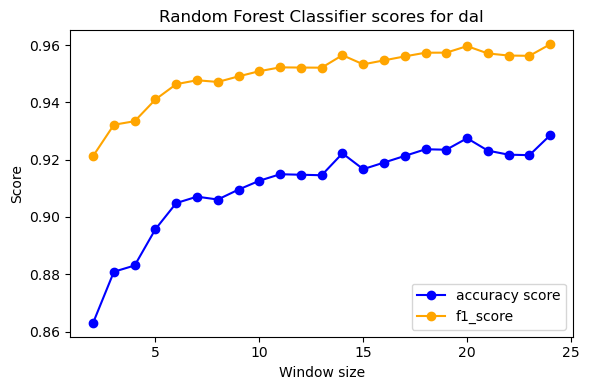

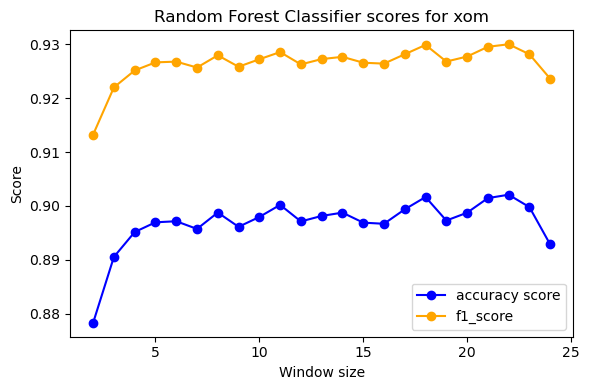

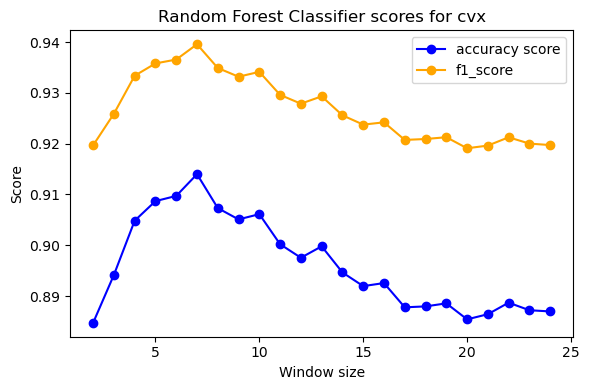

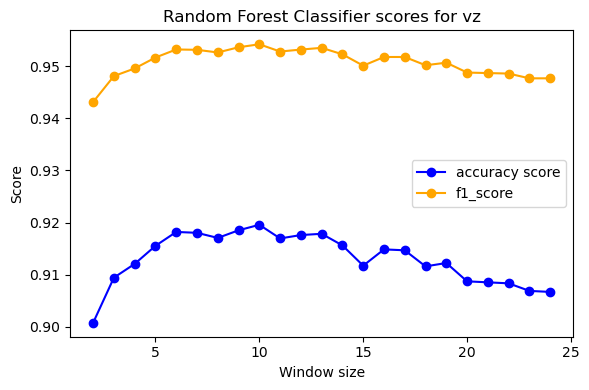

In [72]:
plot_accuracies(f1_rfc,"Random Forest Classifier")

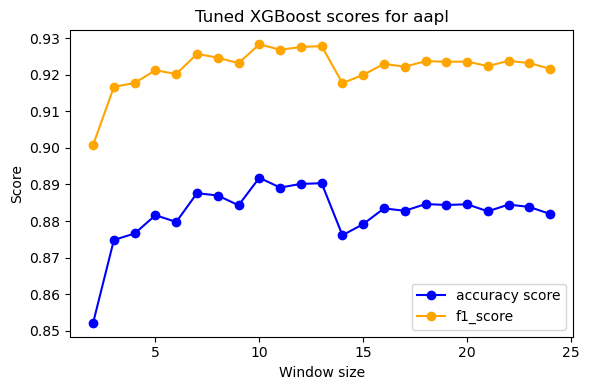

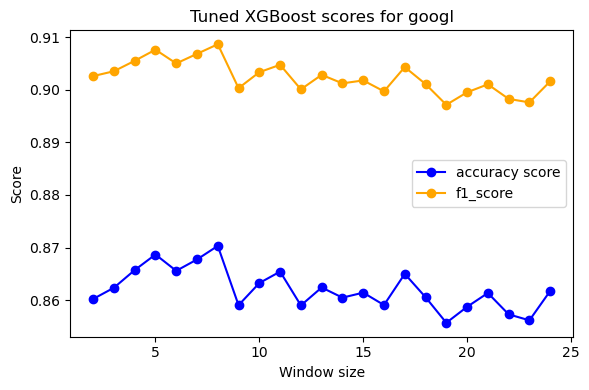

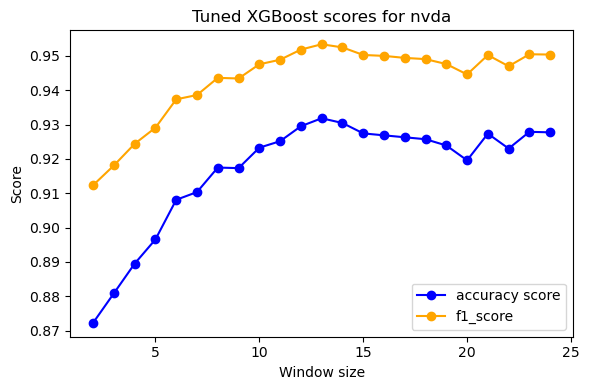

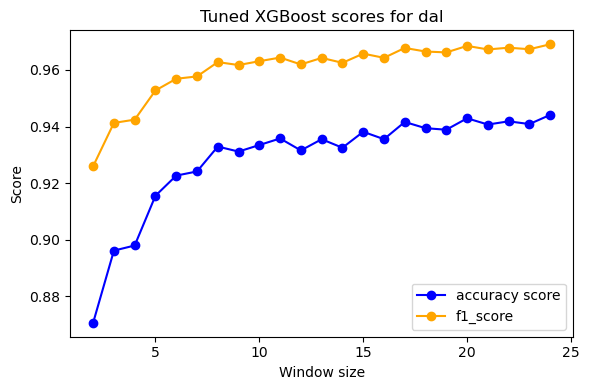

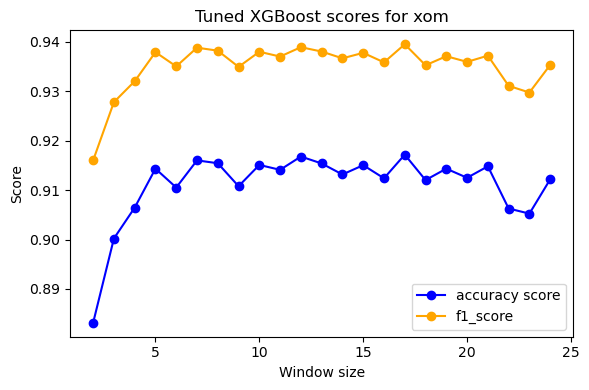

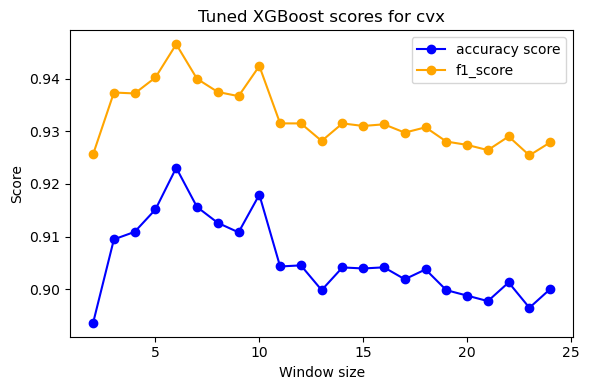

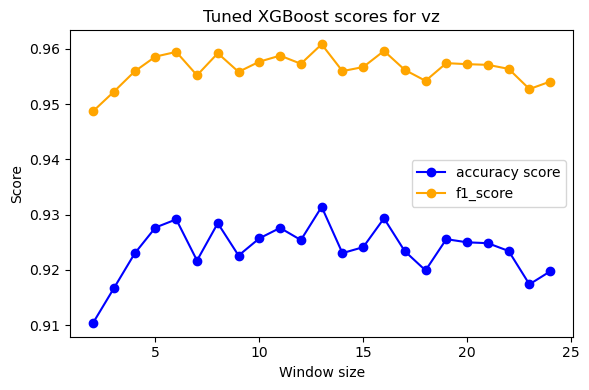

In [45]:
plot_accuracies(f1_tuned,"Tuned XGBoost")

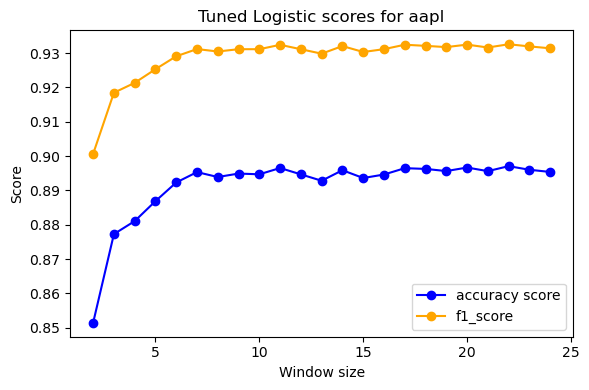

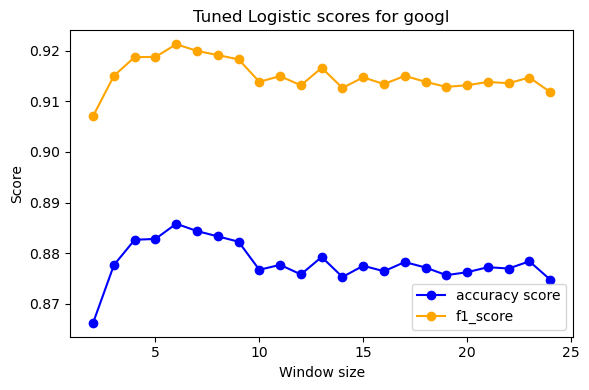

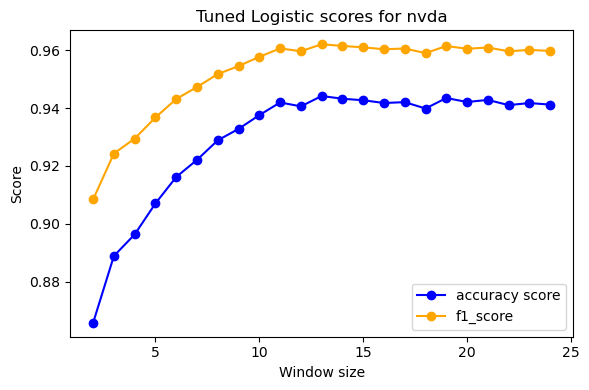

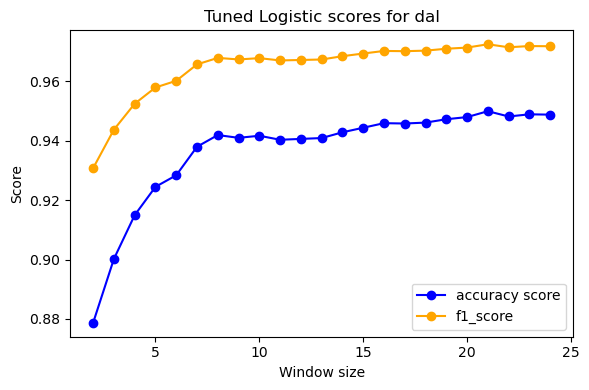

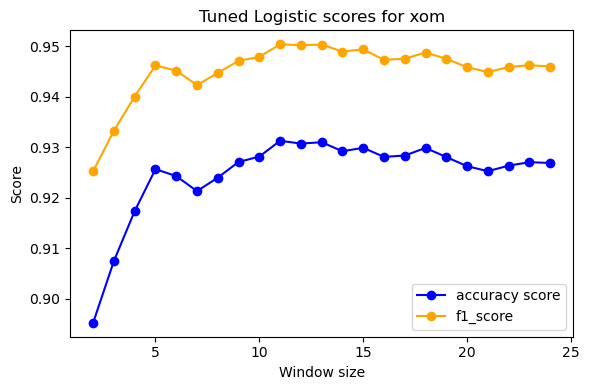

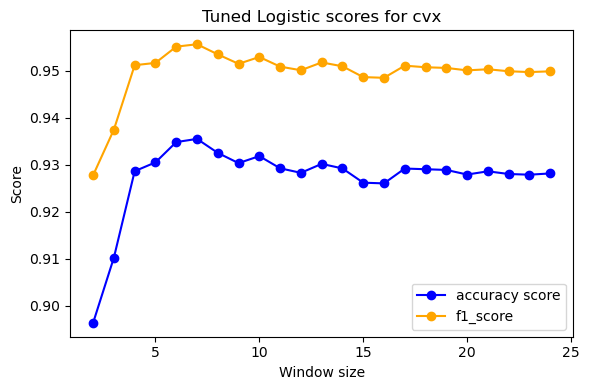

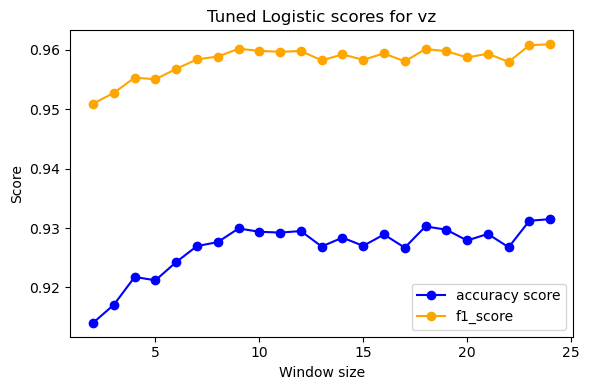

In [30]:
plot_accuracies(f1_logistic_tuned, "Tuned Logistic")